In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [3]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [4]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [5]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [6]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS", "CB"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in contact
    def is_contact(description):
        return 1 if description in ["foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score", 'hit_into_play'] else 0 
    # Define a function to determine if the pitch resulted in a fly ball
    def is_fly_ball(bb_type):
        return 1 if bb_type == "fly_ball" else 0
    
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df

    def calculate_pitcher_stats(df):
        # Group by pitcher and pitch type
        grouped = df.groupby(['pitcher', 'pitch_type_condensed'])

        # Calculate mean for pfx_x, pfx_z, and velocity
        mean_values = grouped[['pfx_x', 'pfx_z', 'release_speed']].mean()
        mean_values = mean_values.rename(columns={'pfx_x': 'pfx_x_avg',
                                                  'pfx_z': 'pfx_z_avg',
                                                  'release_speed': 'avg_velo'})

        # Calculate max for pfx_x and pfx_z
        max_values = grouped[['pfx_x', 'pfx_z', 'release_speed']].max()
        max_values = max_values.rename(columns={'pfx_x': 'pfx_x_max',
                                                'pfx_z': 'pfx_z_max',
                                                'release_speed': 'max_velo'})

        # Combine mean and max values
        combined_stats = pd.concat([mean_values, max_values], axis=1)

        return combined_stats.reset_index()

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Call the new function and store the result
    pitcher_stats = calculate_pitcher_stats(df)

    df = df.merge(pitcher_stats, how='left', on=['pitcher', 'pitch_type_condensed'])

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']


    df['contact'] = df['description'].apply(is_contact)

    df['total_movement'] = np.sqrt(df['pfx_x']**2 + df['pfx_z']**2)

    df['fb'] = df['bb_type'].apply(is_fly_ball)

    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [7]:
# Apply the function to the 'pitch_type' column
data_processed = preprocess_data(data, height_df)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
training_data = data_processed.query('contact == 1')
testing_data_processed = preprocess_data(testing_data, height_df)


In [8]:
fastball_training = training_data.query('pitch_type_condensed in ("FF", "SI", "CT")')
fastball_testing = testing_data_processed.query('pitch_type_condensed in ("FF", "SI", "CT")')
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [9]:
# Now, separate features and identifiers
training_identifiers = fastball_training[['pitch_id_raw']]
testing_identifiers = fastball_testing[['pitch_id_raw']]
training_features = fastball_training.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'contact',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = fastball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'contact',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [10]:
train_data = training_features.drop(['fb'], axis=1).copy()
train_label = training_features['fb'].copy()
testing_data = testing_features.drop(['fb'], axis=1).copy()
testing_label = testing_features['fb'].copy()

In [11]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'pfx_x_avg', 'pfx_z_avg', 'avg_velo', 'pfx_x_max', 'pfx_z_max',
       'max_velo', 'height_numeric'],
      dtype='object')

In [12]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'pfx_x_avg', 'pfx_z_avg', 'avg_velo', 'pfx_x_max', 'pfx_z_max',
       'max_velo', 'height_numeric'],
      dtype='object')

In [13]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [14]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [15]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5289624246172878
Log Loss: 0.6763141387716958


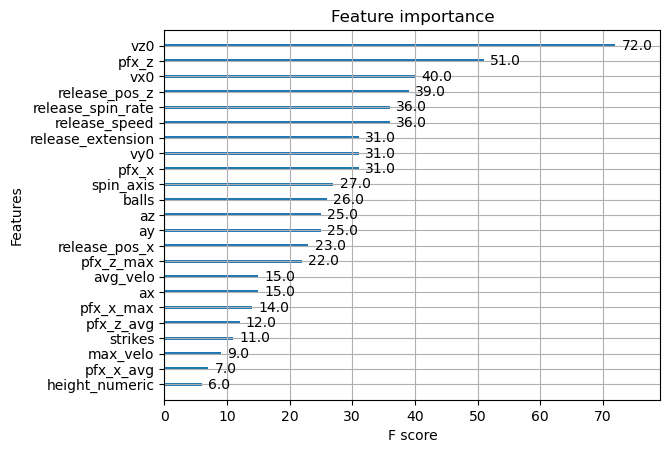

In [16]:
xgb.plot_importance(model)
plt.show()

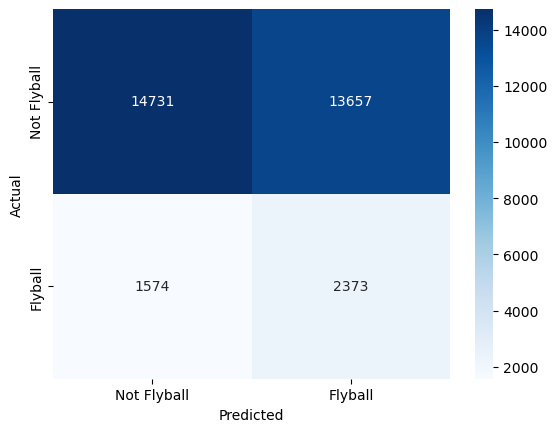

In [17]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Flyball', 'Flyball'], yticklabels=['Not Flyball', 'Flyball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [18]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [19]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-13 11:54:16,380] A new study created in memory with name: no-name-a84247ea-5ce6-4c8e-8693-395b98aa9849


[0]	eval-logloss:0.68269
[1]	eval-logloss:0.67444
[2]	eval-logloss:0.66877
[3]	eval-logloss:0.66319
[4]	eval-logloss:0.65910
[5]	eval-logloss:0.65618
[6]	eval-logloss:0.65163
[7]	eval-logloss:0.64886
[8]	eval-logloss:0.64629
[9]	eval-logloss:0.64425
[10]	eval-logloss:0.64195
[11]	eval-logloss:0.63943
[12]	eval-logloss:0.63665
[13]	eval-logloss:0.63627
[14]	eval-logloss:0.63470
[15]	eval-logloss:0.63274
[16]	eval-logloss:0.63046
[17]	eval-logloss:0.62801
[18]	eval-logloss:0.62665
[19]	eval-logloss:0.62469
[20]	eval-logloss:0.62297
[21]	eval-logloss:0.62286
[22]	eval-logloss:0.62153
[23]	eval-logloss:0.62014
[24]	eval-logloss:0.61959
[25]	eval-logloss:0.61746
[26]	eval-logloss:0.61342
[27]	eval-logloss:0.61049
[28]	eval-logloss:0.60865
[29]	eval-logloss:0.60707
[30]	eval-logloss:0.60450
[31]	eval-logloss:0.60400
[32]	eval-logloss:0.60225
[33]	eval-logloss:0.60112
[34]	eval-logloss:0.59870
[35]	eval-logloss:0.59763
[36]	eval-logloss:0.59596
[37]	eval-logloss:0.59438
[38]	eval-logloss:0.59

[I 2023-11-13 11:54:20,630] Trial 0 finished with value: 0.5290358399987539 and parameters: {'max_depth': 9, 'eta': 0.22050414016706332, 'subsample': 0.7998459581804918, 'colsample_bytree': 0.8778677941569634}. Best is trial 0 with value: 0.5290358399987539.


[0]	eval-logloss:0.68711
[1]	eval-logloss:0.68376
[2]	eval-logloss:0.68099
[3]	eval-logloss:0.67857
[4]	eval-logloss:0.67675
[5]	eval-logloss:0.67551
[6]	eval-logloss:0.67390
[7]	eval-logloss:0.67240
[8]	eval-logloss:0.67062
[9]	eval-logloss:0.66922
[10]	eval-logloss:0.66844
[11]	eval-logloss:0.66777
[12]	eval-logloss:0.66709
[13]	eval-logloss:0.66768
[14]	eval-logloss:0.66620
[15]	eval-logloss:0.66543
[16]	eval-logloss:0.66453
[17]	eval-logloss:0.66338
[18]	eval-logloss:0.66316
[19]	eval-logloss:0.66253
[20]	eval-logloss:0.66121
[21]	eval-logloss:0.66114
[22]	eval-logloss:0.66019
[23]	eval-logloss:0.66014
[24]	eval-logloss:0.66014
[25]	eval-logloss:0.65939
[26]	eval-logloss:0.65791
[27]	eval-logloss:0.65686
[28]	eval-logloss:0.65622
[29]	eval-logloss:0.65528
[30]	eval-logloss:0.65419
[31]	eval-logloss:0.65475
[32]	eval-logloss:0.65379
[33]	eval-logloss:0.65355
[34]	eval-logloss:0.65340
[35]	eval-logloss:0.65216
[36]	eval-logloss:0.65148
[37]	eval-logloss:0.65099
[38]	eval-logloss:0.65

[I 2023-11-13 11:54:23,233] Trial 1 finished with value: 0.6229669189521937 and parameters: {'max_depth': 6, 'eta': 0.25794068007302096, 'subsample': 0.7432698233150679, 'colsample_bytree': 0.7580764059888766}. Best is trial 0 with value: 0.5290358399987539.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68633
[2]	eval-logloss:0.68413
[3]	eval-logloss:0.68286
[4]	eval-logloss:0.68185
[5]	eval-logloss:0.68150
[6]	eval-logloss:0.68082
[7]	eval-logloss:0.68038
[8]	eval-logloss:0.67926
[9]	eval-logloss:0.67790
[10]	eval-logloss:0.67729
[11]	eval-logloss:0.67676
[12]	eval-logloss:0.67648
[13]	eval-logloss:0.67683
[14]	eval-logloss:0.67642
[15]	eval-logloss:0.67650
[16]	eval-logloss:0.67593
[17]	eval-logloss:0.67490
[18]	eval-logloss:0.67514
[19]	eval-logloss:0.67467
[20]	eval-logloss:0.67401
[21]	eval-logloss:0.67420
[22]	eval-logloss:0.67405
[23]	eval-logloss:0.67360
[24]	eval-logloss:0.67346
[25]	eval-logloss:0.67384
[26]	eval-logloss:0.67329
[27]	eval-logloss:0.67279
[28]	eval-logloss:0.67243
[29]	eval-logloss:0.67217
[30]	eval-logloss:0.67113
[31]	eval-logloss:0.67105
[32]	eval-logloss:0.67117
[33]	eval-logloss:0.67120
[34]	eval-logloss:0.67071
[35]	eval-logloss:0.67018
[36]	eval-logloss:0.67005
[37]	eval-logloss:0.66954
[38]	eval-logloss:0.66

[I 2023-11-13 11:54:25,270] Trial 2 finished with value: 0.6581932750457733 and parameters: {'max_depth': 4, 'eta': 0.24514866379950845, 'subsample': 0.8710696876752277, 'colsample_bytree': 0.8869061622891626}. Best is trial 0 with value: 0.5290358399987539.


[0]	eval-logloss:0.68921
[1]	eval-logloss:0.68665
[2]	eval-logloss:0.68465
[3]	eval-logloss:0.68294
[4]	eval-logloss:0.68129
[5]	eval-logloss:0.68045
[6]	eval-logloss:0.67953
[7]	eval-logloss:0.67871
[8]	eval-logloss:0.67735
[9]	eval-logloss:0.67599
[10]	eval-logloss:0.67548
[11]	eval-logloss:0.67521
[12]	eval-logloss:0.67464
[13]	eval-logloss:0.67464
[14]	eval-logloss:0.67453
[15]	eval-logloss:0.67456
[16]	eval-logloss:0.67362
[17]	eval-logloss:0.67243
[18]	eval-logloss:0.67242
[19]	eval-logloss:0.67190
[20]	eval-logloss:0.67113
[21]	eval-logloss:0.67072
[22]	eval-logloss:0.67034
[23]	eval-logloss:0.66972
[24]	eval-logloss:0.66990
[25]	eval-logloss:0.67014
[26]	eval-logloss:0.66956
[27]	eval-logloss:0.66897
[28]	eval-logloss:0.66831
[29]	eval-logloss:0.66803
[30]	eval-logloss:0.66710
[31]	eval-logloss:0.66694
[32]	eval-logloss:0.66630
[33]	eval-logloss:0.66632
[34]	eval-logloss:0.66633
[35]	eval-logloss:0.66595
[36]	eval-logloss:0.66558
[37]	eval-logloss:0.66488
[38]	eval-logloss:0.66

[I 2023-11-13 11:54:27,607] Trial 3 finished with value: 0.6492468035503437 and parameters: {'max_depth': 5, 'eta': 0.20512231021522684, 'subsample': 0.8311468204224549, 'colsample_bytree': 0.7476741726791054}. Best is trial 0 with value: 0.5290358399987539.


[0]	eval-logloss:0.68964
[1]	eval-logloss:0.68766
[2]	eval-logloss:0.68594
[3]	eval-logloss:0.68475
[4]	eval-logloss:0.68364
[5]	eval-logloss:0.68338
[6]	eval-logloss:0.68250
[7]	eval-logloss:0.68204
[8]	eval-logloss:0.68026
[9]	eval-logloss:0.67902
[10]	eval-logloss:0.67853
[11]	eval-logloss:0.67800
[12]	eval-logloss:0.67777
[13]	eval-logloss:0.67822
[14]	eval-logloss:0.67789
[15]	eval-logloss:0.67760
[16]	eval-logloss:0.67713
[17]	eval-logloss:0.67643
[18]	eval-logloss:0.67679
[19]	eval-logloss:0.67627
[20]	eval-logloss:0.67532
[21]	eval-logloss:0.67554
[22]	eval-logloss:0.67532
[23]	eval-logloss:0.67524
[24]	eval-logloss:0.67599
[25]	eval-logloss:0.67585
[26]	eval-logloss:0.67499
[27]	eval-logloss:0.67447
[28]	eval-logloss:0.67439
[29]	eval-logloss:0.67392
[30]	eval-logloss:0.67299
[31]	eval-logloss:0.67340
[32]	eval-logloss:0.67287
[33]	eval-logloss:0.67219
[34]	eval-logloss:0.67225
[35]	eval-logloss:0.67174
[36]	eval-logloss:0.67126
[37]	eval-logloss:0.67108
[38]	eval-logloss:0.67

[I 2023-11-13 11:54:29,581] Trial 4 finished with value: 0.6616373395951718 and parameters: {'max_depth': 4, 'eta': 0.21556271344608155, 'subsample': 0.7472705951302389, 'colsample_bytree': 0.7188667453898907}. Best is trial 0 with value: 0.5290358399987539.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69218
[2]	eval-logloss:0.69176
[3]	eval-logloss:0.69137
[4]	eval-logloss:0.69100
[5]	eval-logloss:0.69072
[6]	eval-logloss:0.69036
[7]	eval-logloss:0.69003
[8]	eval-logloss:0.68952
[9]	eval-logloss:0.68906
[10]	eval-logloss:0.68875
[11]	eval-logloss:0.68848
[12]	eval-logloss:0.68822
[13]	eval-logloss:0.68803
[14]	eval-logloss:0.68779
[15]	eval-logloss:0.68752
[16]	eval-logloss:0.68731
[17]	eval-logloss:0.68702
[18]	eval-logloss:0.68690
[19]	eval-logloss:0.68672
[20]	eval-logloss:0.68647
[21]	eval-logloss:0.68630
[22]	eval-logloss:0.68616
[23]	eval-logloss:0.68598
[24]	eval-logloss:0.68595
[25]	eval-logloss:0.68595
[26]	eval-logloss:0.68571
[27]	eval-logloss:0.68548
[28]	eval-logloss:0.68530
[29]	eval-logloss:0.68513
[30]	eval-logloss:0.68488
[31]	eval-logloss:0.68481
[32]	eval-logloss:0.68470
[33]	eval-logloss:0.68457
[34]	eval-logloss:0.68447
[35]	eval-logloss:0.68432
[36]	eval-logloss:0.68420
[37]	eval-logloss:0.68402
[38]	eval-logloss:0.68

[I 2023-11-13 11:54:31,794] Trial 5 finished with value: 0.679585237394138 and parameters: {'max_depth': 3, 'eta': 0.037331132333936375, 'subsample': 0.791381717413854, 'colsample_bytree': 0.6095281111282512}. Best is trial 0 with value: 0.5290358399987539.


[0]	eval-logloss:0.68883
[1]	eval-logloss:0.68509
[2]	eval-logloss:0.68180
[3]	eval-logloss:0.67889
[4]	eval-logloss:0.67637
[5]	eval-logloss:0.67496
[6]	eval-logloss:0.67286
[7]	eval-logloss:0.67093
[8]	eval-logloss:0.66885
[9]	eval-logloss:0.66644
[10]	eval-logloss:0.66531
[11]	eval-logloss:0.66399
[12]	eval-logloss:0.66248
[13]	eval-logloss:0.66278
[14]	eval-logloss:0.66197
[15]	eval-logloss:0.66150
[16]	eval-logloss:0.66007
[17]	eval-logloss:0.65900
[18]	eval-logloss:0.65909
[19]	eval-logloss:0.65842
[20]	eval-logloss:0.65776
[21]	eval-logloss:0.65719
[22]	eval-logloss:0.65683
[23]	eval-logloss:0.65654
[24]	eval-logloss:0.65618
[25]	eval-logloss:0.65547
[26]	eval-logloss:0.65438
[27]	eval-logloss:0.65335
[28]	eval-logloss:0.65337
[29]	eval-logloss:0.65330
[30]	eval-logloss:0.65228
[31]	eval-logloss:0.65215
[32]	eval-logloss:0.65074
[33]	eval-logloss:0.65014
[34]	eval-logloss:0.64937
[35]	eval-logloss:0.64845
[36]	eval-logloss:0.64791
[37]	eval-logloss:0.64711
[38]	eval-logloss:0.64

[I 2023-11-13 11:54:34,866] Trial 6 finished with value: 0.6175328785849177 and parameters: {'max_depth': 7, 'eta': 0.14578785722300167, 'subsample': 0.6247447890760662, 'colsample_bytree': 0.7293607253422587}. Best is trial 0 with value: 0.5290358399987539.


[0]	eval-logloss:0.68242
[1]	eval-logloss:0.67452
[2]	eval-logloss:0.66844
[3]	eval-logloss:0.66397
[4]	eval-logloss:0.65871
[5]	eval-logloss:0.65636
[6]	eval-logloss:0.65531
[7]	eval-logloss:0.65310
[8]	eval-logloss:0.64941
[9]	eval-logloss:0.64714
[10]	eval-logloss:0.64409
[11]	eval-logloss:0.64207
[12]	eval-logloss:0.64058
[13]	eval-logloss:0.64158
[14]	eval-logloss:0.63808
[15]	eval-logloss:0.63655
[16]	eval-logloss:0.63302
[17]	eval-logloss:0.63005
[18]	eval-logloss:0.62951
[19]	eval-logloss:0.62907
[20]	eval-logloss:0.62611
[21]	eval-logloss:0.62591
[22]	eval-logloss:0.62640
[23]	eval-logloss:0.62523
[24]	eval-logloss:0.62332
[25]	eval-logloss:0.62079
[26]	eval-logloss:0.61880
[27]	eval-logloss:0.61679
[28]	eval-logloss:0.61705
[29]	eval-logloss:0.61599
[30]	eval-logloss:0.61315
[31]	eval-logloss:0.61277
[32]	eval-logloss:0.61030
[33]	eval-logloss:0.61065
[34]	eval-logloss:0.60905
[35]	eval-logloss:0.60696
[36]	eval-logloss:0.60561
[37]	eval-logloss:0.60483
[38]	eval-logloss:0.60

[I 2023-11-13 11:54:39,560] Trial 7 finished with value: 0.5370544501553298 and parameters: {'max_depth': 9, 'eta': 0.2230699415111466, 'subsample': 0.6223752207027671, 'colsample_bytree': 0.9620073462089567}. Best is trial 0 with value: 0.5290358399987539.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69144
[3]	eval-logloss:0.69083
[4]	eval-logloss:0.69038
[5]	eval-logloss:0.68998
[6]	eval-logloss:0.68955
[7]	eval-logloss:0.68914
[8]	eval-logloss:0.68865
[9]	eval-logloss:0.68808
[10]	eval-logloss:0.68770
[11]	eval-logloss:0.68733
[12]	eval-logloss:0.68694
[13]	eval-logloss:0.68660
[14]	eval-logloss:0.68628
[15]	eval-logloss:0.68588
[16]	eval-logloss:0.68560
[17]	eval-logloss:0.68519
[18]	eval-logloss:0.68496
[19]	eval-logloss:0.68464
[20]	eval-logloss:0.68432
[21]	eval-logloss:0.68409
[22]	eval-logloss:0.68380
[23]	eval-logloss:0.68351
[24]	eval-logloss:0.68328
[25]	eval-logloss:0.68307
[26]	eval-logloss:0.68277
[27]	eval-logloss:0.68249
[28]	eval-logloss:0.68223
[29]	eval-logloss:0.68200
[30]	eval-logloss:0.68175
[31]	eval-logloss:0.68152
[32]	eval-logloss:0.68138
[33]	eval-logloss:0.68123
[34]	eval-logloss:0.68107
[35]	eval-logloss:0.68089
[36]	eval-logloss:0.68071
[37]	eval-logloss:0.68052
[38]	eval-logloss:0.68

[I 2023-11-13 11:54:42,419] Trial 8 finished with value: 0.6729906006976574 and parameters: {'max_depth': 5, 'eta': 0.02859830923545577, 'subsample': 0.8941255118648874, 'colsample_bytree': 0.6036538915950354}. Best is trial 0 with value: 0.5290358399987539.


[0]	eval-logloss:0.68804
[1]	eval-logloss:0.68352
[2]	eval-logloss:0.68025
[3]	eval-logloss:0.67739
[4]	eval-logloss:0.67520
[5]	eval-logloss:0.67373
[6]	eval-logloss:0.67182
[7]	eval-logloss:0.67037
[8]	eval-logloss:0.66757
[9]	eval-logloss:0.66554
[10]	eval-logloss:0.66417
[11]	eval-logloss:0.66327
[12]	eval-logloss:0.66250
[13]	eval-logloss:0.66224
[14]	eval-logloss:0.66096
[15]	eval-logloss:0.66029
[16]	eval-logloss:0.65895
[17]	eval-logloss:0.65769
[18]	eval-logloss:0.65718
[19]	eval-logloss:0.65619
[20]	eval-logloss:0.65515
[21]	eval-logloss:0.65476
[22]	eval-logloss:0.65478
[23]	eval-logloss:0.65444
[24]	eval-logloss:0.65406
[25]	eval-logloss:0.65391
[26]	eval-logloss:0.65249
[27]	eval-logloss:0.65160
[28]	eval-logloss:0.65082
[29]	eval-logloss:0.65025
[30]	eval-logloss:0.64965
[31]	eval-logloss:0.64886
[32]	eval-logloss:0.64744
[33]	eval-logloss:0.64719
[34]	eval-logloss:0.64615
[35]	eval-logloss:0.64464
[36]	eval-logloss:0.64393
[37]	eval-logloss:0.64338
[38]	eval-logloss:0.64

[I 2023-11-13 11:54:46,019] Trial 9 finished with value: 0.611145585138598 and parameters: {'max_depth': 7, 'eta': 0.16555062140496687, 'subsample': 0.6657917954660096, 'colsample_bytree': 0.9331475821290796}. Best is trial 0 with value: 0.5290358399987539.


[0]	eval-logloss:0.68093
[1]	eval-logloss:0.67163
[2]	eval-logloss:0.66403
[3]	eval-logloss:0.65860
[4]	eval-logloss:0.65413
[5]	eval-logloss:0.65117
[6]	eval-logloss:0.64658
[7]	eval-logloss:0.64434
[8]	eval-logloss:0.64237
[9]	eval-logloss:0.64033
[10]	eval-logloss:0.63686
[11]	eval-logloss:0.63602
[12]	eval-logloss:0.63352
[13]	eval-logloss:0.63351
[14]	eval-logloss:0.63001
[15]	eval-logloss:0.62822
[16]	eval-logloss:0.62532
[17]	eval-logloss:0.62319
[18]	eval-logloss:0.62116
[19]	eval-logloss:0.61892
[20]	eval-logloss:0.61719
[21]	eval-logloss:0.61617
[22]	eval-logloss:0.61311
[23]	eval-logloss:0.61105
[24]	eval-logloss:0.60976
[25]	eval-logloss:0.60876
[26]	eval-logloss:0.60627
[27]	eval-logloss:0.60404
[28]	eval-logloss:0.60247
[29]	eval-logloss:0.60096
[30]	eval-logloss:0.59835
[31]	eval-logloss:0.59742
[32]	eval-logloss:0.59612
[33]	eval-logloss:0.59468
[34]	eval-logloss:0.59235
[35]	eval-logloss:0.59088
[36]	eval-logloss:0.58926
[37]	eval-logloss:0.58769
[38]	eval-logloss:0.58

[I 2023-11-13 11:54:50,372] Trial 10 finished with value: 0.5203021276676721 and parameters: {'max_depth': 9, 'eta': 0.29609692979447993, 'subsample': 0.8090682368205566, 'colsample_bytree': 0.8413583391355054}. Best is trial 10 with value: 0.5203021276676721.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.67108
[2]	eval-logloss:0.66495
[3]	eval-logloss:0.65927
[4]	eval-logloss:0.65386
[5]	eval-logloss:0.65140
[6]	eval-logloss:0.64741
[7]	eval-logloss:0.64412
[8]	eval-logloss:0.64191
[9]	eval-logloss:0.64030
[10]	eval-logloss:0.63801
[11]	eval-logloss:0.63574
[12]	eval-logloss:0.63432
[13]	eval-logloss:0.63502
[14]	eval-logloss:0.63253
[15]	eval-logloss:0.63026
[16]	eval-logloss:0.62609
[17]	eval-logloss:0.62478
[18]	eval-logloss:0.62392
[19]	eval-logloss:0.62191
[20]	eval-logloss:0.61984
[21]	eval-logloss:0.61767
[22]	eval-logloss:0.61508
[23]	eval-logloss:0.61301
[24]	eval-logloss:0.61022
[25]	eval-logloss:0.60861
[26]	eval-logloss:0.60597
[27]	eval-logloss:0.60271
[28]	eval-logloss:0.60079
[29]	eval-logloss:0.59816
[30]	eval-logloss:0.59625
[31]	eval-logloss:0.59536
[32]	eval-logloss:0.59371
[33]	eval-logloss:0.59262
[34]	eval-logloss:0.58923
[35]	eval-logloss:0.58750
[36]	eval-logloss:0.58520
[37]	eval-logloss:0.58314
[38]	eval-logloss:0.58

[I 2023-11-13 11:54:55,061] Trial 11 finished with value: 0.5213930701273657 and parameters: {'max_depth': 9, 'eta': 0.2899316913287843, 'subsample': 0.7992865439697957, 'colsample_bytree': 0.8510302691423625}. Best is trial 10 with value: 0.5203021276676721.


[0]	eval-logloss:0.68355
[1]	eval-logloss:0.67603
[2]	eval-logloss:0.67077
[3]	eval-logloss:0.66717
[4]	eval-logloss:0.66395
[5]	eval-logloss:0.66122
[6]	eval-logloss:0.65769
[7]	eval-logloss:0.65551
[8]	eval-logloss:0.65348
[9]	eval-logloss:0.65052
[10]	eval-logloss:0.64826
[11]	eval-logloss:0.64698
[12]	eval-logloss:0.64659
[13]	eval-logloss:0.64598
[14]	eval-logloss:0.64361
[15]	eval-logloss:0.64210
[16]	eval-logloss:0.63996
[17]	eval-logloss:0.63785
[18]	eval-logloss:0.63815
[19]	eval-logloss:0.63656
[20]	eval-logloss:0.63441
[21]	eval-logloss:0.63235
[22]	eval-logloss:0.63103
[23]	eval-logloss:0.62922
[24]	eval-logloss:0.62843
[25]	eval-logloss:0.62781
[26]	eval-logloss:0.62585
[27]	eval-logloss:0.62462
[28]	eval-logloss:0.62158
[29]	eval-logloss:0.62157
[30]	eval-logloss:0.61994
[31]	eval-logloss:0.61913
[32]	eval-logloss:0.61739
[33]	eval-logloss:0.61722
[34]	eval-logloss:0.61537
[35]	eval-logloss:0.61425
[36]	eval-logloss:0.61359
[37]	eval-logloss:0.61201
[38]	eval-logloss:0.61

[I 2023-11-13 11:54:58,854] Trial 12 finished with value: 0.5561631608635087 and parameters: {'max_depth': 8, 'eta': 0.2974240207756913, 'subsample': 0.8377832679186923, 'colsample_bytree': 0.8360387349245597}. Best is trial 10 with value: 0.5203021276676721.


[0]	eval-logloss:0.68281
[1]	eval-logloss:0.67437
[2]	eval-logloss:0.66940
[3]	eval-logloss:0.66591
[4]	eval-logloss:0.66266
[5]	eval-logloss:0.66059
[6]	eval-logloss:0.65846
[7]	eval-logloss:0.65709
[8]	eval-logloss:0.65300
[9]	eval-logloss:0.65118
[10]	eval-logloss:0.64910
[11]	eval-logloss:0.64708
[12]	eval-logloss:0.64605
[13]	eval-logloss:0.64630
[14]	eval-logloss:0.64533
[15]	eval-logloss:0.64396
[16]	eval-logloss:0.64203
[17]	eval-logloss:0.63871
[18]	eval-logloss:0.63853
[19]	eval-logloss:0.63772
[20]	eval-logloss:0.63414
[21]	eval-logloss:0.63358
[22]	eval-logloss:0.63277
[23]	eval-logloss:0.63133
[24]	eval-logloss:0.62991
[25]	eval-logloss:0.62970
[26]	eval-logloss:0.62655
[27]	eval-logloss:0.62410
[28]	eval-logloss:0.62350
[29]	eval-logloss:0.62258
[30]	eval-logloss:0.62054
[31]	eval-logloss:0.62022
[32]	eval-logloss:0.61920
[33]	eval-logloss:0.61845
[34]	eval-logloss:0.61602
[35]	eval-logloss:0.61496
[36]	eval-logloss:0.61388
[37]	eval-logloss:0.61344
[38]	eval-logloss:0.61

[I 2023-11-13 11:55:03,014] Trial 13 finished with value: 0.550821234920847 and parameters: {'max_depth': 8, 'eta': 0.2959381760281445, 'subsample': 0.7814116117064589, 'colsample_bytree': 0.979005733538939}. Best is trial 10 with value: 0.5203021276676721.
[W 2023-11-13 11:55:03,347] Trial 14 failed with parameters: {'max_depth': 9, 'eta': 0.2897935707731847, 'subsample': 0.7207612780286807, 'colsample_bytree': 0.8245366073991582} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_6272\404348879.py", line 16, in objective
    model = xgb.train(
            ^^^^^^^^^^
  File "C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py", line 729, in inner_f
    

KeyboardInterrupt: 

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.5052220705498275
Best hyperparameters: {'max_depth': 9, 'eta': 0.29976992917341805, 'subsample': 0.8917184421679565, 'colsample_bytree': 0.9831357629334501}


# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio,
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [ ]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5683624555435287
Log Loss: 0.6429587586158263


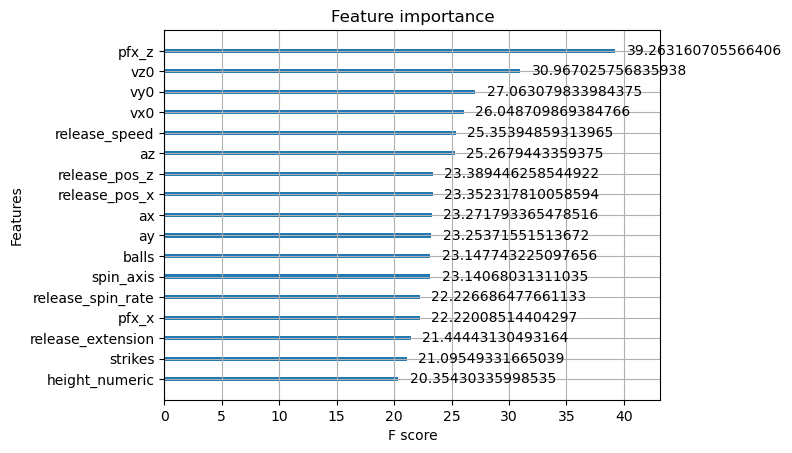

In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

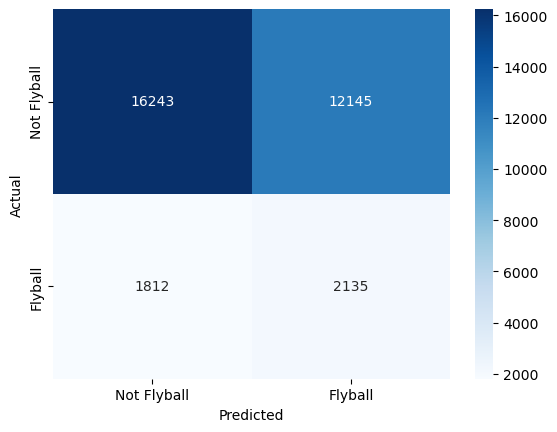

In [ ]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Flyball', 'Flyball'], yticklabels=['Not Flyball', 'Flyball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [ ]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [ ]:
y_pred = final_model.predict(predictions)

In [ ]:
testing_identifiers['xfb'] = y_pred

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_23456\3115553546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xfb'] = y_pred


In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/fb_2022&3_xfb.csv")